In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, mean_absolute_error
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Bidirectional,Multiply, Permute, Reshape, Flatten, Activation, RepeatVector, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

In [ ]:
def load_kaggle_data(filepath):

    # Load CSV file
    df = pd.read_csv(filepath)

    # Standardize column names
    rename_map = {
        'Open time': 'Date',
        'Open': 'Open',
        'High': 'High',
        'Low': 'Low',
        'Close': 'Close',
        'Volume': 'Volume'
    }
    df.rename(columns=rename_map, inplace=True)

    # Parse date column
    df['Date'] = pd.to_datetime(df['Date'])

    # Set date as index and sort
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

    # Filter relevant columns (OHLCV)
    final_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df = df[final_cols]

    print(f"Data Loaded: {len(df)} rows.")
    print(f"Start: {df.index[0]}")
    print(f"End: {df.index[-1]}")

    return df

filename = 'btc_1h_data_2018_to_2025.csv'

try:
    df_btc = load_kaggle_data(filename)
    print("\nPreview Last 5 Rows:")
    print(df_btc.tail())
except FileNotFoundError:
    print(f"Error: File {filename} not found. Please ensure it is uploaded.")

--- Loading data dari: btc_1h_data_2018_to_2025.csv ---
Data Loaded: 69455 baris.
Start: 2018-01-01 00:00:00
End: NaT

Preview 5 Data Terakhir:
                         Open      High       Low     Close     Volume
Date                                                                  
2025-12-08 18:00:00  90257.98  90527.30  89724.72  89921.68  559.47994
2025-12-08 19:00:00  89921.68  90366.39  89860.07  90124.48  342.53116
2025-12-08 20:00:00  90124.49  90917.23  90124.49  90799.92  565.06678
2025-12-08 21:00:00  90799.92  91374.00  90675.00  91316.01  579.83297
NaT                  91316.00  91373.69  90726.40  90833.86  391.90576


In [ ]:
def process_data(df):
    data = df.copy()

    # Feature Engineering
    
    # Log Returns
    data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))

    # Candle Shadows (Relative to Close)
    data['Upper_Shadow'] = (data['High'] - data[['Close', 'Open']].max(axis=1)) / data['Close']
    data['Lower_Shadow'] = (data[['Close', 'Open']].min(axis=1) - data['Low']) / data['Close']

    # Log Volume Change
    data['Log_Vol'] = np.log(data['Volume'] / data['Volume'].shift(1).replace(0, 1))

    # Technical Indicators

    # RSI (14-period)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Normalized MACD
    ema12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD_Norm'] = (ema12 - ema26) / data['Close']

    # Target Creation
    
    prediction_horizon = 1

    # Future Returns
    data['Return_Future'] = data['Close'].shift(-prediction_horizon) / data['Close'] - 1

    # Direction (Binary 0/1)
    data['Target_Dir'] = (data['Return_Future'] > 0).astype(int)

    # Volatility
    data['Target_Vol'] = data['Return_Future'].abs()

    # Clean Dataset
    
    # Remove NaNs and Infinite values
    data.dropna(inplace=True)
    data.replace([np.inf, -np.inf], 0, inplace=True)

    return data

raw_prices = df_btc[['Open', 'High', 'Low', 'Close']].copy()

df_final = process_data(df_btc)
print(df_final[['Log_Ret', 'Target_Dir', 'Target_Vol']].tail())

Data Siap! Input sekarang pakai Persentase, bukan Harga Dolar.
                      Log_Ret  Target_Dir  Target_Vol
Date                                                 
2025-12-08 14:00:00 -0.006749           0    0.010246
2025-12-08 15:00:00 -0.009858           1    0.001813
2025-12-08 16:00:00  0.000190           1    0.009129
2025-12-08 17:00:00  0.003101           1    0.011722
2025-12-08 18:00:00 -0.003733           1    0.010144


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
def create_sequences(data, target_dir, target_vol, seq_len):
    # Creates input sequences for LSTM
    X, y_dir, y_vol = [], [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y_dir.append(target_dir[i])
        y_vol.append(target_vol[i])
    return np.array(X), np.array(y_dir), np.array(y_vol)

# Data Splitting
# 80% Train, 10% Val, 10% Test
n = len(df_final)
train_df = df_final[0 : int(n * 0.8)]
val_df   = df_final[int(n * 0.8) : int(n * 0.9)]
test_df  = df_final[int(n * 0.9) :]

# Scaling
feature_cols = [c for c in df_final.columns if 'Target' not in c and 'Return' not in c]
print(f"Features: {feature_cols}")

scaler = MinMaxScaler()
scaler.fit(train_df[feature_cols])

train_scaled = scaler.transform(train_df[feature_cols])
val_scaled   = scaler.transform(val_df[feature_cols])
test_scaled  = scaler.transform(test_df[feature_cols])

# Sequence Generation
SEQ_LEN = 60 

print("Creating sequences...")
X_train, y_train_dir, y_train_vol = create_sequences(
    train_scaled, train_df['Target_Dir'].values, train_df['Target_Vol'].values, SEQ_LEN
)
X_val, y_val_dir, y_val_vol = create_sequences(
    val_scaled, val_df['Target_Dir'].values, val_df['Target_Vol'].values, SEQ_LEN
)
X_test, y_test_dir, y_test_vol = create_sequences(
    test_scaled, test_df['Target_Dir'].values, test_df['Target_Vol'].values, SEQ_LEN
)

print(f"\nTrain Shape: {X_train.shape}")
print(f"Target Dir Shape: {y_train_dir.shape}")
print(f"Target Vol Shape: {y_train_vol.shape}")

Fitur yang dipakai: ['Open', 'High', 'Low', 'Close', 'Volume', 'Log_Ret', 'Upper_Shadow', 'Lower_Shadow', 'Log_Vol', 'RSI', 'MACD_Norm']
Sedang membuat sequence... (Tunggu sebentar)

Shape Input Train: (55490, 60, 11)
Shape Target Arah: (55490,)
Shape Target Volatilitas: (55490,)


In [ ]:
def attention_layer(inputs, time_steps):
    # Prepare dimensions
    a = Permute((2, 1))(inputs)
    a = Reshape((inputs.shape[2], time_steps))(a)
    
    # Calculate attention scores
    a = Dense(time_steps, activation='softmax')(a)
    
    # Permute back
    a_probs = Permute((2, 1), name='attention_vec')(a)
    
    # Apply attention weights
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def build_attention_model(input_shape, learning_rate=0.0005):
    inputs = Input(shape=input_shape)

    # LSTM layers
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    lstm_out = Dropout(0.3)(lstm_out)

    # Attention mechanism
    attention_mul = attention_layer(lstm_out, input_shape[0])

    # Dense layers
    x = Flatten()(attention_mul)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output heads
    # Direction (Classification)
    dir_branch = Dense(32, activation='relu')(x)
    output_dir = Dense(1, activation='sigmoid', name='out_dir')(dir_branch)

    # Volatility (Regression)
    vol_branch = Dense(32, activation='relu')(x)
    output_vol = Dense(1, activation='relu', name='out_vol')(vol_branch)

    # Model compilation
    model = Model(inputs=inputs, outputs=[output_dir, output_vol])

    losses = {'out_dir': 'binary_crossentropy', 'out_vol': 'mse'}
    loss_weights = {'out_dir': 50.0, 'out_vol': 1.0}

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=losses,
        loss_weights=loss_weights,
        metrics=[['accuracy'], ['mae']]
    )

    return model

def load_trained_model(model_path):
    # Load model
    if not os.path.exists(model_path):
        return None
    return load_model(model_path, custom_objects={'attention_layer': attention_layer})

Arsitektur LSTM + Attention:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 60, 128)   │     38,912 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 60, 128)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 128, 60)   │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 60)   │          0 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 60)   │      3,660 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_vec       │ (None, 60, 128)   │          0 │ dense[0][0]       │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 60, 128)   │          0 │ dropout[0][0],    │
│                     │                   │            │ attention_vec[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 7680)      │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │    491,584 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_dir (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_vol (Dense)     │ (None, 1)         │         33 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 538,382 (2.05 MB)

 Trainable params: 538,382 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def plot_training_history(history):
    # Setup figure size
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training and validation loss
    ax.plot(history.history['loss'], label='Total Train Loss')
    ax.plot(history.history['val_loss'], label='Total Val Loss')

    # Set labels and grid
    ax.set_title('Overall Model Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()

--- Menyiapkan Data & Training (Hard Reset) ---
--- Mulai Training... ---
Epoch 1/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 34.6653 - out_dir_accuracy: 0.5038 - out_dir_loss: 0.6931 - out_vol_loss: 0.0098 - out_vol_mae: 0.0089
Epoch 1: val_loss improved from inf to 34.61473, saving model to combine_model.keras
868/868 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 34.6653 - out_dir_accuracy: 0.5038 - out_dir_loss: 0.6931 - out_vol_loss: 0.0098 - out_vol_mae: 0.0089 - val_loss: 34.6147 - val_out_dir_accuracy: 0.5183 - val_out_dir_loss: 0.6923 - val_out_vol_loss: 7.1334e-05 - val_out_vol_mae: 0.0068 - learning_rate: 5.0000e-04
Epoch 2/50
868/868 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 34.6279 - out_dir_accuracy: 0.5125 - out_dir_loss: 0.6925 - out_vol_loss: 0.0012 - out_vol_mae: 0.0084
Epoch 2: val_loss improved from 34.61473 to 34.60690, saving model to combine_model.keras
868/868 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 34.6279 - out_dir_accuracy: 0.5125 - out_dir_loss: 0.69

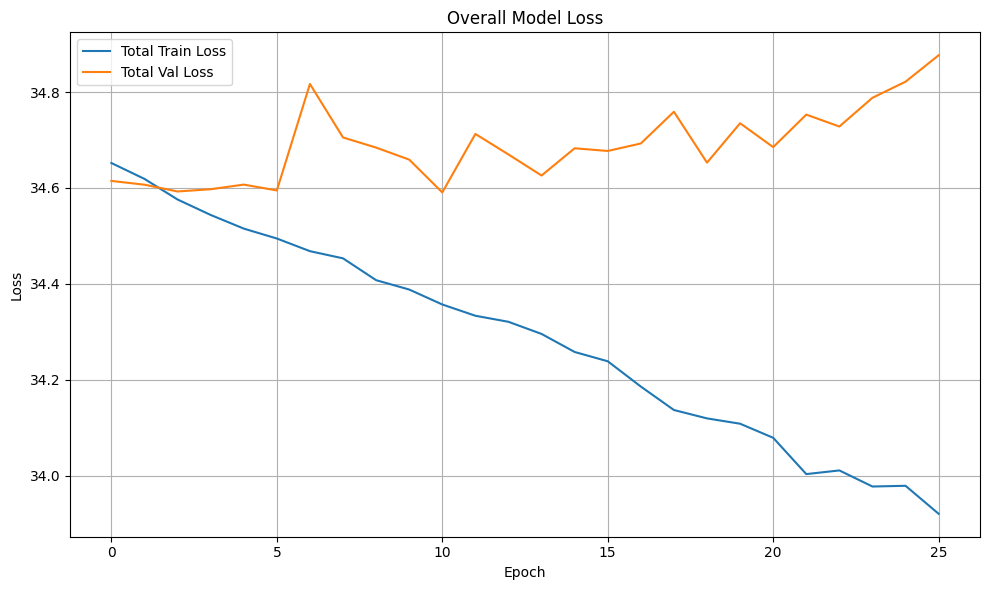

In [ ]:
# 1. Convert data to float32
X_train_final = X_train.astype('float32')
X_val_final = X_val.astype('float32')

# Direction (Binary 0/1)
y_train_dir_final = np.array(y_train_dir).astype('float32')
y_val_dir_final = np.array(y_val_dir).astype('float32')

# Volatility (Continuous/Decimal)
y_train_vol_final = np.array(y_train_vol).astype('float32')
y_val_vol_final = np.array(y_val_vol).astype('float32')

# Re-compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=['binary_crossentropy', 'mse'],
    loss_weights=[50.0, 1.0],        # Prioritize Direction accuracy
    metrics=[['accuracy'], ['mae']]
)

# Setup Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

checkpoint_path = "combine_model.keras"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_final,
    [y_train_dir_final, y_train_vol_final],
    validation_data=(X_val_final, [y_val_dir_final, y_val_vol_final]),
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

model.load_weights(checkpoint_path)
plot_training_history(history)

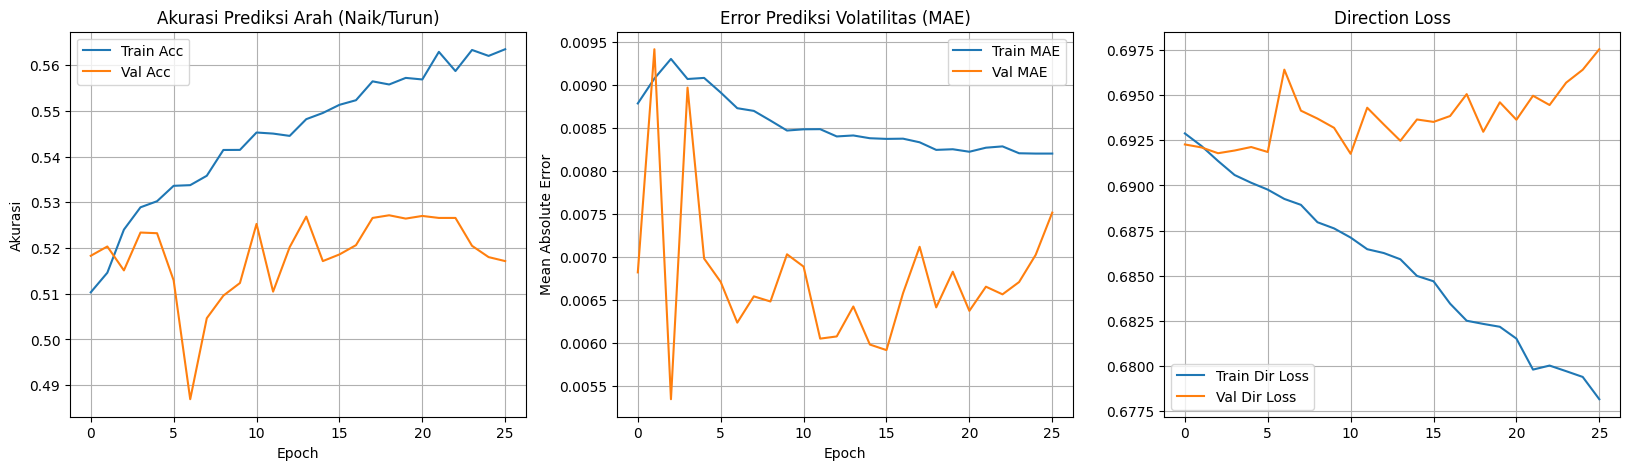

In [ ]:
def plot_history(history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # Plot 1: Direction Accuracy
    ax1.plot(history.history['out_dir_accuracy'], label='Train Acc')
    ax1.plot(history.history['val_out_dir_accuracy'], label='Val Acc')
    ax1.set_title('Direction Prediction Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Volatility Error (MAE)
    ax2.plot(history.history['out_vol_mae'], label='Train MAE')
    ax2.plot(history.history['val_out_vol_mae'], label='Val MAE')
    ax2.set_title('Volatility Prediction Error (MAE)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Direction Loss
    ax3.plot(history.history['out_dir_loss'], label='Train Dir Loss')
    ax3.plot(history.history['val_out_dir_loss'], label='Val Dir Loss')
    ax3.set_title('Direction Loss')
    ax3.legend()
    ax3.grid(True)

    plt.show()

plot_history(history)

In [ ]:
preds = model.predict(X_test, verbose=0)
pred_dir_probs = preds[0].flatten()
pred_vol = preds[1].flatten()

# Check Model Confidence Statistics
print(f"Max Probability (Confident Up): {pred_dir_probs.max():.4f}")
print(f"Min Probability (Confident Down): {pred_dir_probs.min():.4f}")
print(f"Average Probability: {pred_dir_probs.mean():.4f}")

# Basic Classification
pred_dir_classes = (pred_dir_probs > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test_dir, pred_dir_classes, target_names=['DOWN', 'UP']))

# Dynamic Filter Simulation
# Set threshold slightly above average confidence
threshold = 0.51
print(f"\nSIMULATION (Threshold > {threshold})")

mask_confident = (pred_dir_probs > threshold) | (pred_dir_probs < (1 - threshold))
mask_volatile = pred_vol > 0.003

# Combine filters
final_mask = mask_confident & mask_volatile
selected_indices = np.where(final_mask)[0]

if len(selected_indices) > 0:
    # Get data passing the filter
    filtered_preds = pred_dir_classes[selected_indices]
    filtered_actuals = y_test_dir[selected_indices]

    # Calculate manual accuracy
    correct = (filtered_preds == filtered_actuals).sum()
    total = len(selected_indices)
    acc = correct / total

    print(f"Found {total} trading signals.")
    print(f"SMART FILTER ACCURACY: {acc:.2%} (Win Rate)")
else:
    print("No signals passed the filter yet.")

--- DIAGNOSA HASIL MODEL V2 ---
Probabilitas Tertinggi (Yakin Naik): 0.8071
Probabilitas Terendah (Yakin Turun): 0.4303
Rata-rata Probabilitas: 0.5108

Laporan Klasifikasi:
              precision    recall  f1-score   support

       TURUN       0.52      0.58      0.55      3418
        NAIK       0.54      0.48      0.51      3466

    accuracy                           0.53      6884
   macro avg       0.53      0.53      0.53      6884
weighted avg       0.53      0.53      0.53      6884


--- SIMULASI (Threshold > 0.51) ---
Ditemukan 6251 sinyal trading.
AKURASI SMART FILTER: 53.38% (Win Rate)


In [ ]:
print("MODEL PREDICTION DEMO (LIVE SIMULATION - LAST 100 HOURS)")

# Select last 100 data points
last_indices = range(-100, 0)
sample_X = X_test[last_indices]
sample_dates = test_df.index[last_indices]

# Generate predictions
preds = model.predict(sample_X, verbose=0)
pred_probs = preds[0].flatten()
pred_vols = preds[1].flatten()

# Print Table Header
print(f"\n{'DATE':<20} | {'PREDICTION':<10} | {'PROBABILITY':<12} | {'VOLATILITY':<12} | {'RECOMMENDATION'}")

for i in range(len(sample_X)):
    date = str(sample_dates[i])[:16]
    prob = pred_probs[i]
    vol = pred_vols[i]

    # 1. Determine Direction & Raw Probability
    if prob > 0.5:
        direction = "UP 🟢"
        display_prob = prob * 100
    else:
        direction = "DOWN 🔴"
        display_prob = (1 - prob) * 100

    # 2. Volatility to Percentage
    vol_pct = vol * 100

    # 3. Action Recommendation (Logic Threshold)
    threshold_strong = 53.0 # High confidence
    threshold_weak = 50.5   # Moderate confidence

    if display_prob > threshold_strong:
        if "UP" in direction: action = "STRONG BUY 🚀"
        else: action = "STRONG SELL 📉"
    elif display_prob > threshold_weak:
        if "UP" in direction: action = "Buy (Weak)"
        else: action = "Sell (Weak)"
    else:
        action = "WAIT (Neutral) ✋"

    print(f"{date:<20} | {direction:<10} | {display_prob:>11.2f}% | {vol_pct:>10.2f}% | {action}")

print(f"Displayed: Last {len(sample_X)} data points.")

--- DEMO PREDIKSI MODEL (SIMULASI LIVE - 50 JAM TERAKHIR) ---

TANGGAL              | PREDIKSI   | PROBABILITAS | VOLATILITAS  | REKOMENDASI
-------------------------------------------------------------------------------------
2025-12-04 15:00     | NAIK 🟢     |       50.22% |       1.04% | WAIT (Neutral) ✋
2025-12-04 16:00     | TURUN 🔴    |       50.82% |       1.12% | Sell (Weak)
2025-12-04 17:00     | NAIK 🟢     |       50.83% |       1.13% | Buy (Weak)
2025-12-04 18:00     | NAIK 🟢     |       53.37% |       1.09% | STRONG BUY 🚀
2025-12-04 19:00     | NAIK 🟢     |       54.77% |       1.07% | STRONG BUY 🚀
2025-12-04 20:00     | NAIK 🟢     |       57.90% |       1.02% | STRONG BUY 🚀
2025-12-04 21:00     | NAIK 🟢     |       57.65% |       1.00% | STRONG BUY 🚀
2025-12-04 22:00     | NAIK 🟢     |       58.72% |       1.00% | STRONG BUY 🚀
2025-12-04 23:00     | NAIK 🟢     |       58.97% |       0.99% | STRONG BUY 🚀
2025-12-05 00:00     | NAIK 🟢     |       60.04% |       1.02% | STRON